In [186]:
# import needed libraries
import  json
import requests

import pandas as pd
import numpy as np

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib.pyplot as plt

In [187]:
# load json data 
url = "http://youdrive.today/info"
r = requests.get(url)
yd_data = r.json()
# check what's inside
print(yd_data.keys())

dict_keys(['cars', 'area', 'areas', 'area_groups', 'layers', 'success'])


In [193]:
# read cars data as df
df_cars = pd.DataFrame(yd_data['cars'])
df_cars = df_cars[df_cars.model != 'Electric scooter lite'] # remove scooters

# read areas data as df in form 'longitude', 'latitude', 'name_area'
list_df_areas = []
for area_name, area_data in yd_data['areas'].items():
    df_tmp = pd.DataFrame(area_data)
    df_tmp['name_area'] = area_name
    list_df_areas.append(pd.DataFrame(df_tmp))
df_areas = pd.concat(list_df_areas, ignore_index = "True")

# read areas data as df in form 'longitude', 'latitude', 'number_area'
list_df_areas = []
n = 0
for area_data in yd_data['area']:
    df_tmp = pd.DataFrame(area_data)
    df_tmp['number_area'] = n
    n = n+1
    list_df_areas.append(pd.DataFrame(df_tmp))
df_area = pd.concat(list_df_areas, ignore_index = "True")

In [200]:
# create polygons corresponding each area from areas and save to a dict
areas_list = list(yd_data['areas'].keys())
areas_list = [area for area in areas_list if 'YouDriveLite' not in area]
dict_area_name_to_poly = dict()
for area_name in areas_list:
    lon_vect = df_areas[df_areas.name_area==area_name].longitude
    lat_vect = df_areas[df_areas.name_area==area_name].latitude
    lon_lat_vect = np.column_stack((lon_vect, lat_vect))
    poly = Polygon(lon_lat_vect)
    dict_area_name_to_poly[area_name]=poly

In [202]:
# add 'area_name' column with name of area where car is 
def check_point_in_poly(polygon, lon, lat):
    return polygon.contains( Point(lon, lat) )
    
df_cars['area_name'] = 'not_in_any_area'
for area_name, area_poly in dict_area_name_to_poly.items():    
    df_cars.loc[df_cars.apply(lambda x:check_point_in_poly(area_poly,x.longitude,x.latitude), axis=1),'area_name'] = area_name

In [203]:
# create dict area to city(area group)
dict_area_to_city = dict()
for city, area_list in yd_data['area_groups'].items():
    for area in area_list:
        if area not in dict_area_to_city:
            dict_area_to_city[area]=city
            
# add 'city' column to cars
df_cars['city'] = df_cars.area_name.map(dict_area_to_city).fillna("unknown")

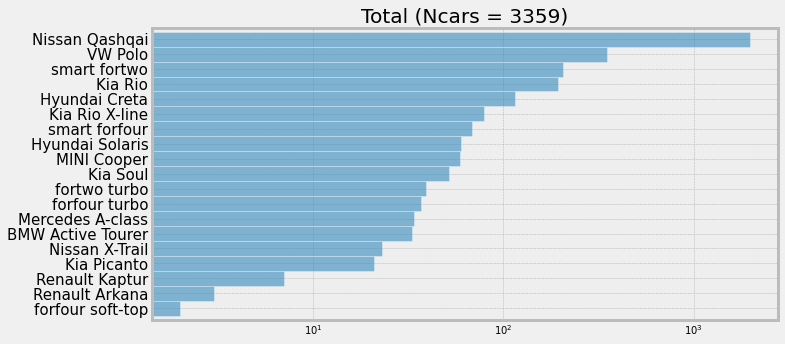

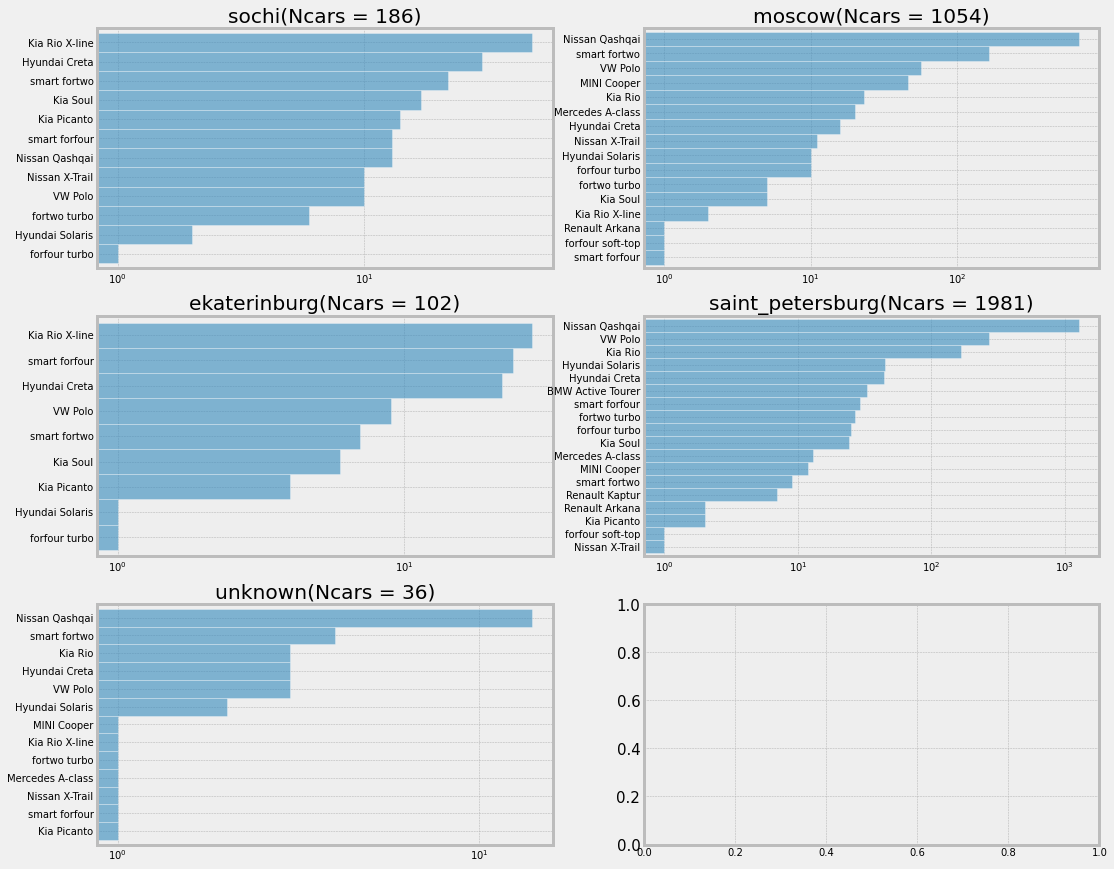

In [204]:
# TASK 1
# cars distribution depending on area/city
plt.style.use('bmh')
# total cars distribution
n_cars = df_cars.shape[0]
ax=df_cars.model.value_counts().plot.barh( figsize=(10, 5), logx=True, edgecolor='white', alpha=0.6,width=1, 
                                          title='Total (Ncars = '+str(n_cars)+')')
ax.invert_yaxis()

# distribution by city
fig, axes = plt.subplots(3,2, figsize=(16,14))
for i,city in enumerate(set(df_cars.city)):
    ax = axes.flatten()[i]
    n_cars = df_cars[df_cars.city==city].shape[0]
    df_cars[df_cars.city==city].model.value_counts().plot.barh(ax=ax, logx=True, fontsize=10, 
                                                               title=city+'(Ncars = '+str(n_cars)+')',
                                                               edgecolor='white', alpha=0.6,width=1)
    ax.invert_yaxis()

# Выводы:
# 1. Самая частая машина по всему автопарку - Nissan Qashqai 
# 2. Он же (Nissan Qashqai) - самая распространеннная машина для Москвы и Петербурга
# 3. В Сочи и Екатеринбурге самая частая машина - Kia Rio X-line

Text(71.12607025900566, 402.57, 'Mean: 70.42')

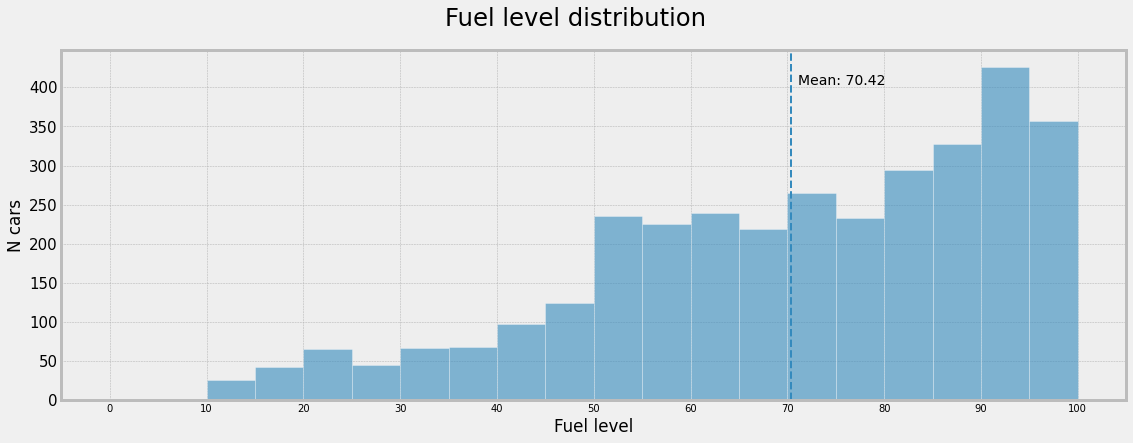

In [234]:
# TASK 2
# cars fuel distribution
ax = df_cars.fuel.hist(figsize=(17, 6), bins=range(0,105,5), edgecolor='white', alpha=0.6) 
plt.suptitle('Fuel level distribution', ha='center', fontsize='xx-large')
ax.set_xlabel("Fuel level")
ax.set_ylabel("N cars")
ax.set_xticks(range(0,110,10))
# mean line
mean_fuel = df_cars.fuel.mean()
plt.axvline(mean_fuel,  linestyle='dashed')
min_ylim, max_ylim = plt.ylim()
plt.text(mean_fuel*1.01, max_ylim*0.9, 'Mean: {:.2f}'.format(mean_fuel))
# Выводы:
# 1. Большая часть машин имеет высокий уровень топлива - 90-100% 
# 2. Для уровня топлива 50-80% видим плато - примерно одинаковое количество машин. Оно относится к машинам, проехавшим 
#   типичное расстояние, но этот уровень еще не требует заправки.
# 3. Резкое снижение после 50%. Вероятно с этого момента машина требует заправки, что делают сотрудники компании 
#   с достаточной оперативностью.

<AxesSubplot:xlabel='model', ylabel='fuel'>

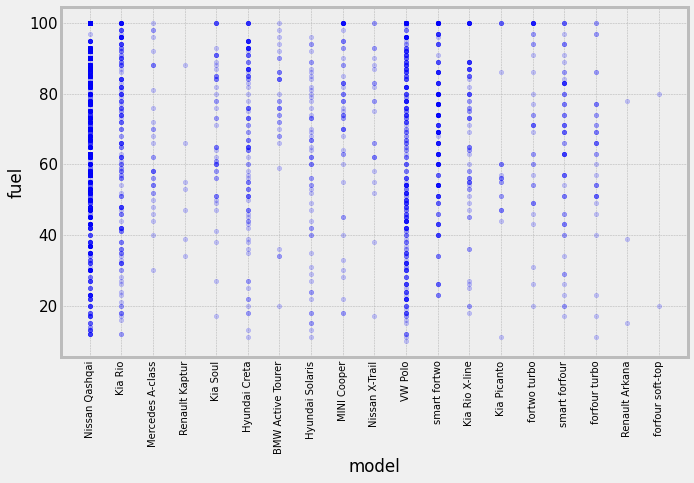

In [235]:
# TASK 2 continue 1
# fuel distribution depending on car model
# Проверим, связан ли уровень топлива с моделью машины?
df_cars.plot.scatter(x='model', y='fuel', alpha=0.2, rot=90, figsize=(10, 6))

# Не связан, для каждой из моделей наблюдаем такое же распределение, как и по всем машинам в целом.

<AxesSubplot:xlabel='area_name', ylabel='fuel'>

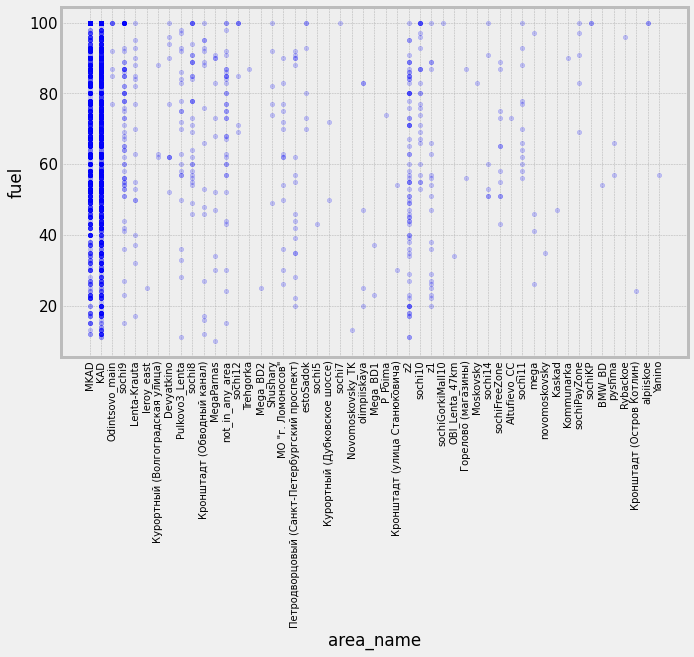

In [236]:
# TASK 2 continue 2
# fuel distribution depending on areas (is in areas out of the city fuel level is lower?) 
# Проверим, зависит ли распределение топлива от зоны?
df_cars.plot.scatter(x='area_name', y='fuel', alpha=0.2, rot=90, figsize=(10, 6))
# Снова не видно выраженной зависимости

In [74]:
# TASK 3
# Режим "Передача".
# Если файл с данными о машинах был скачан в дневное время - все машины вне какой-либо зоны находятся в режиме передачи.
# Скачивая данные периодически (например, раз в час в течении недели/месяца исключая ночное время), можно смотреть 
# как меняется количество машин в режиме "Передача".  
n_handing_over = df_cars[df_cars.area_name == 'not_in_any_area' ].shape[0]
n_tot = df_cars.shape[0]
print('Количество машин в режиме передачи: ', n_handing_over)
print('Процент от общего числа: ',round(n_handing_over/n_tot*100,1),'%')

Количество машин в режиме передачи:  40
Процент от общего числа:  1.3 %


In [67]:
# TASK 3 continue
# Так как машин в режиме передачи немного, не стоит спешить с расширением зоны в места, где оставляют такие машины.  
# Нужно посмотреть как много пользователей YouDrive(или потенциальных клиентов) находится в этих местах, 
# чтобы машину кто-то мог взять, и ее не пришлось перегонять сотрудникам.
# Оптимальные зоны - там где много как берут, так и оставляют. Такие места можно увидеть если, например, есть данные о 
# местоположении пользователей: взяв статистику за некоторое время, посмотреть, где много пользователей остаются
# продолжительное время. Там, где пользователи останавливаются - как раз те места куда им надо приехать и откуда уехать.
# Так же можно обратить внимание, если машины скапливаются на границе зоны. Возможно в этом месте ее стоит расширить.
# Как потенциальные места расширения зон, можно рассмотреть зоны конкурентов, которых нет в YouDrive, учтя популярность 
# их использования.

In [75]:
# TASK 4
# Конкуренты.
# Какую информацию могут получить из открытых данных:
# 1. Парк автомобилей - размер и состав (в том числе в зависимости от города). Если брать данные ночью,
#   когда большинство машин свободно и находятся в открытых данных - эта информация будет наиболее полной.
# 2. Зоны действия. В частности эта информация говорит о наличии клиентов каршеринга в этих областях.
# 3. Актуальность сервиса по городам. Сравнивая количество свободных машин днем и ночью, можно оценить насколько 
#   каршеринг популярен в данном городе. Чем ближе число ночью и в часы пик - тем менее популярен сервис.
# 4. Распределение машин по зонам. В ночное время это будут места, где клиенты оставляют машины (и где будет спрос с утра). 
#   В дневное время - это вероятно места работы/пересадки. В этих местах будет спрос вечером.
# 5. Мониторинг столбца is_parther позволит отслеживать прогресс в партнерских отношениях YouDrive.
# 6. Популярность сервиса в течении времени. По временным срезам можно оценить востребованность в течении дня/месяца/года.
#  (Чем больше процент свободных машин - тем менее востребован сервис)
# 7. Уровень топлива как показатель проблем или хорошего сервиса. Высокий процент машин с низким уровнем топлива может означать 
# материально-технические проблемы или низкий уровень сервиса и наоборот. 